## Data cleaning

In [21]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import statsmodels.api as sm
from statsmodels.formula.api import ols
from scipy import stats
from tabulate import tabulate
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import seaborn as sns
from scipy.stats import ks_2samp

In [22]:
df = pd.read_csv('dati_survey.csv')
df = df[~(df['DistributionChannel']=='preview')].reset_index(drop=True)

In [3]:
df = df.drop([
    'StartDate', 'EndDate', 'IPAddress', 'Duration (in seconds)', 'RecordedDate', 'ResponseId', 
    'RecipientLastName', 'RecipientFirstName', 'Progress', 'Status','RecipientEmail', 'ExternalReference', 
    'LocationLatitude', 'LocationLongitude', 'Q_DataPolicyViolations', 'Q_StraightliningCount', 
    'Q_StraightliningPercentage','Q_StraightliningQuestions', 'Finished', 'DistributionChannel', 'UserLanguage'
             ], axis = 1) #drop useless cols

df = df.drop([0,1]).reset_index(drop=True) #drop questions

df.columns = [
    'age', 'gender', 'occupation', 'license','live_milan', 'days_car', 
    'likert_car_when_rain', 'likert_covered_parking', 'likert_covered_parking_rain', 'price_proximity', 
    'subscribed', 'Q29', 'subscription_no_treat', 'subscriprion_treat', 
    'rainy_weekday', 'rainy_weekend', 'dry_weekday', 'dry_weekend']

In [4]:
df = df.drop(list(df[df['age']=='<18'].index))
df = df[df['license']=='Yes'] #focus only on those with a license
df = df[df['live_milan']=='Yes'] #focus only on those living in milan/often in milan
df = df.drop(['live_milan', 'license'], axis = 1)

Just one null value for age, that row has other columns in line with the average and it does not seem to be a significant outlier. It can be dropped

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 183 entries, 0 to 284
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   age                          182 non-null    object
 1   gender                       183 non-null    object
 2   occupation                   183 non-null    object
 3   days_car                     183 non-null    object
 4   likert_car_when_rain         183 non-null    object
 5   likert_covered_parking       183 non-null    object
 6   likert_covered_parking_rain  183 non-null    object
 7   price_proximity              183 non-null    object
 8   subscribed                   93 non-null     object
 9   Q29                          7 non-null      object
 10  subscription_no_treat        43 non-null     object
 11  subscriprion_treat           43 non-null     object
 12  rainy_weekday                19 non-null     object
 13  rainy_weekend                23 non-null

In [6]:
df[df['age'].isna()]

,age,gender,occupation,days_car,likert_car_when_rain,likert_covered_parking,likert_covered_parking_rain,price_proximity,subscribed,Q29,subscription_no_treat,subscriprion_treat,rainy_weekday,rainy_weekend,dry_weekday,dry_weekend
256,NaN,Female,Working,Mondays to Thursdays,3,3,4,4,NaN,NaN,NaN,NaN,NaN,NaN,2.01,NaN


In [7]:
df = df.dropna(subset = ['age']) #just one with missing age, answers align with the average
df['gender'] = df['gender'].apply(lambda x: 'Non-binary' if x=='Non-binary / third gender' else x)
df['gender_bin'] = df['gender'].apply(lambda x: 1 if x == 'Male' else 0)
df['age'] = df['age'].apply(lambda x: '>55' if x == 'more than 55' else x)
df['occupation'] = df['occupation'].apply(lambda x: 'other' if (x in ('Retired', 'Unemployed', 'Working student')) else x)
names = ['student_dummy', 'working_dummy']
df[names] = pd.get_dummies(df['occupation']).drop('other', axis =1).astype(int)
names = ['24-35_dummy', '36-55_dummy', '>55_dummy']
df[names] = pd.get_dummies(df['age'], drop_first=True).astype(int)

In [8]:
#Creating the first df
sub = df[~df['subscribed'].isna()].copy()
cols = ['subscriprion_treat', 'subscription_no_treat']
sub['treatment'] = sub[cols].apply(lambda row: row.first_valid_index(), axis=1)

In [9]:
#df for those already subscribed
subscribed = sub[sub['treatment'].isna()]
subscribed.to_csv('survey_subscribed.csv', index=False)

In [10]:
sub = sub.dropna(subset=['treatment'])

Encoding the value of the treatment and creating the outcome

In [11]:
sub['treatment'] = sub['treatment'].apply(lambda x: 1 if x=='subscriprion_treat' else 0)
sub['outcome'] = sub['subscriprion_treat'].fillna('') + ' ' + sub['subscription_no_treat'].fillna('')
sub['outcome'] = sub['outcome'].str.strip()
sub['outcome'] = sub['outcome'].apply(lambda x: 1 if x=='Yes' else 0)

In [12]:
sub = sub.drop(['rainy_weekday','rainy_weekend', 'dry_weekday', 'dry_weekend'], axis = 1)
sub = sub.drop(['subscription_no_treat', 'subscriprion_treat', 'subscribed', 'Q29'], axis = 1)

In [13]:
sub.to_csv('survey_sub.csv', index=False)

#### Price theory

In [14]:
price = df[df['subscribed'].isna()].copy()
price = price.drop(['subscription_no_treat', 'subscriprion_treat', 'Q29', 'subscribed'], axis =1)
cols = ['rainy_weekday', 'rainy_weekend', 'dry_weekday', 'dry_weekend']
price['treatment'] = price[cols].apply(lambda row: row.first_valid_index(), axis=1)
price = price.dropna(subset=['treatment'])
price['treatment_rain'] = price['treatment'].apply(lambda x: 1 if 'rainy' in x else 0)
price['treatment_weekday'] = price['treatment'].apply(lambda x: 1 if 'weekday' in x else 0)

In [15]:
price['outcome'] = (price['rainy_weekday'].fillna('') + ' ' 
                    + price['rainy_weekend'].fillna('') + ' '
                    + price['dry_weekday'].fillna('') + ' '
                    + price['dry_weekend'].fillna('')
                   )
price['outcome'] = price['outcome'].str.strip()
#price = price.drop(['rainy_weekday', 'rainy_weekend', 'dry_weekday', 'dry_weekend'], axis = 1)

In [16]:
price.to_csv('survey_price.csv', index=False)

## Data analysis

In [17]:
sub = pd.read_csv('survey_sub.csv')
price = pd.read_csv('survey_price.csv')
subscribed = pd.read_csv('survey_subscribed.csv')

In [18]:
tot = pd.concat([sub, price])

In [20]:
len(tot)+len(subscribed)

177

In [19]:
mean_value = 2.5  
t_stat, p_value = stats.ttest_1samp(tot['likert_car_when_rain'], mean_value)
print("Test for likert scale 'I take the car more often when it rains' different from 2.5'\n")
print(f"Mean: {tot['likert_car_when_rain'].mean()}")
print(f"Test Value: {mean_value}")
print(f"P-value: {p_value}")

print(f"\nMedian: {tot['likert_car_when_rain'].median()}")

Test for likert scale 'I take the car more often when it rains' different from 2.5'

Mean: 3.429411764705882
Test Value: 2.5
P-value: 4.13205917204685e-17

Median: 4.0


In [20]:
mean_value = 2.5  
t_stat, p_value = stats.ttest_1samp(tot['likert_covered_parking'], mean_value)
print("Test for likert scale 'I prefer covered parking lot' different from 2.5'\n")
print(f"Mean value: {tot['likert_covered_parking'].mean()}")
print(f"Test Value: {mean_value}")
print(f"P-value: {p_value}")

print(f"\nMedian: {tot['likert_covered_parking'].median()}")

Test for likert scale 'I prefer covered parking lot' different from 2.5'

Mean value: 2.7411764705882353
Test Value: 2.5
P-value: 0.010358789340639286

Median: 3.0


In [21]:
mean_value = 2.5  
t_stat, p_value = stats.ttest_1samp(tot['likert_covered_parking_rain'], mean_value)
print("Test for likert scale 'I prefer covered parking lot when it rains' different from 2.5'\n")
print(f"Mean value: {tot['likert_covered_parking_rain'].mean()}")
print(f"Test Value: {mean_value}")
print(f"P-value: {p_value}")

print(f"\nMedian: {tot['likert_covered_parking_rain'].median()}")

Test for likert scale 'I prefer covered parking lot when it rains' different from 2.5'

Mean value: 3.411764705882353
Test Value: 2.5
P-value: 4.184890023346734e-17

Median: 4.0


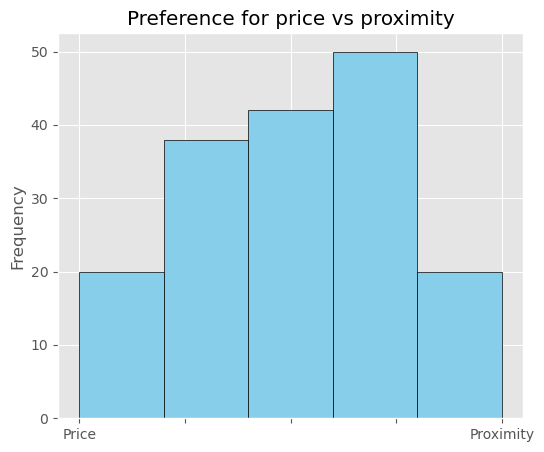

In [22]:
plt.figure(figsize=(6, 5))
plt.hist(np.round(tot['price_proximity']), bins=5, color='skyblue', edgecolor='black') 

plt.xticks(np.arange(1,6), ['Price', '', '', '', 'Proximity'])
plt.ylabel('Frequency')
plt.title('Preference for price vs proximity')

plt.show()

In [23]:
tot['price_proximity'].apply(lambda x: 'price' if x<2.5 else 'proximity').value_counts()/(len(tot))

price_proximity
proximity    0.658824
price        0.341176
Name: count, dtype: float64

## First Theory - parking subscription

### Randomization checks

First we look if the two groups were correctly randomized. Qualtrics should have taken care of this but we still look at the two covariaets age and occupation.

In [24]:
tab = pd.DataFrame(['Chi-sq statistic', 'p_value'])
tab.columns = ['stat']
tab.index = tab['stat']
untreated = sub[sub['treatment']==0]
treated =sub[sub['treatment']==1]

In [25]:
contingency_table = pd.crosstab(sub['treatment'], sub['gender'])
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

contingency_table['Total'] = contingency_table.sum(axis=1)
contingency_table.loc['Total'] = contingency_table.sum(axis=0)
table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')
tab['gender'] = [round(chi2_stat, 3), round(p_val, 3)]

print("Contingency Table:")
print(table_str)

print("Chi-squared test:")
print(f"  Chi-squared statistic: {chi2_stat:.4f}")
print(f"  Degrees of freedom: {dof}")
print(f"  P-value: {p_val:.4f}")

statks, pvalks = ks_2samp(treated['gender'], untreated['gender'])
print(f"\nKs statistic: {statks},\nKs pvalue: {pvalks}")

Contingency Table:
+-----------+--------+------+-------+
| treatment | Female | Male | Total |
+-----------+--------+------+-------+
|     0     |   20   |  23  |  43   |
|     1     |   23   |  20  |  43   |
|   Total   |   43   |  43  |  86   |
+-----------+--------+------+-------+
Chi-squared test:
  Chi-squared statistic: 0.1860
  Degrees of freedom: 1
  P-value: 0.6662

Ks statistic: 0.06976744186046512,
Ks pvalue: 0.9999670303234552


In [26]:
contingency_table = pd.crosstab(sub['treatment'], sub['age'])
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

contingency_table['Total'] = contingency_table.sum(axis=1)
contingency_table.loc['Total'] = contingency_table.sum(axis=0)
table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')
tab['age'] = [round(chi2_stat, 3), round(p_val, 3)]

print("Contingency Table:")
print(table_str)

print("Chi-squared test:")
print(f"  Chi-squared statistic: {chi2_stat:.4f}")
print(f"  Degrees of freedom: {dof}")
print(f"  P-value: {p_val:.4f}")

statks, pvalks = ks_2samp(treated['age'], untreated['age'])
print(f"\nKs statistic: {statks},\nKs pvalue: {pvalks}")

Contingency Table:
+-----------+-------+-------+-------+-----+-------+
| treatment | 18-23 | 24-35 | 36-55 | >55 | Total |
+-----------+-------+-------+-------+-----+-------+
|     0     |  29   |   2   |   9   |  3  |  43   |
|     1     |  29   |   7   |   5   |  2  |  43   |
|   Total   |  58   |   9   |  14   |  5  |  86   |
+-----------+-------+-------+-------+-----+-------+
Chi-squared test:
  Chi-squared statistic: 4.1206
  Degrees of freedom: 3
  P-value: 0.2487

Ks statistic: 0.11627906976744186,
Ks pvalue: 0.9377161273776224


In [27]:
contingency_table = pd.crosstab(sub['treatment'], sub['occupation'])
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

contingency_table['Total'] = contingency_table.sum(axis=1)
contingency_table.loc['Total'] = contingency_table.sum(axis=0)
table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')
tab['occupation'] = [round(chi2_stat, 3), round(p_val, 3)]

print("Contingency Table:")
print(table_str)

print("Chi-squared test:")
print(f"  Chi-squared statistic: {chi2_stat:.4f}")
print(f"  Degrees of freedom: {dof}")
print(f"  P-value: {p_val:.4f}")

statks, pvalks = ks_2samp(treated['occupation'], untreated['occupation'])
print(f"\nKs statistic: {statks},\nKs pvalue: {pvalks}")

Contingency Table:
+-----------+---------+---------+-------+-------+
| treatment | Student | Working | other | Total |
+-----------+---------+---------+-------+-------+
|     0     |   29    |   12    |   2   |  43   |
|     1     |   28    |   11    |   4   |  43   |
|   Total   |   57    |   23    |   6   |  86   |
+-----------+---------+---------+-------+-------+
Chi-squared test:
  Chi-squared statistic: 0.7277
  Degrees of freedom: 2
  P-value: 0.6950

Ks statistic: 0.046511627906976744,
Ks pvalue: 0.9999999999986748


In [28]:
print(tabulate(tab.drop('stat', axis=1), headers='keys', tablefmt='grid'))

+------------------+----------+-------+--------------+
| stat             |   gender |   age |   occupation |
+==================+==========+=======+==============+
| Chi-sq statistic |    0.186 | 4.121 |        0.728 |
+------------------+----------+-------+--------------+
| p_value          |    0.666 | 0.249 |        0.695 |
+------------------+----------+-------+--------------+


<Axes: xlabel='treatment', ylabel='count'>

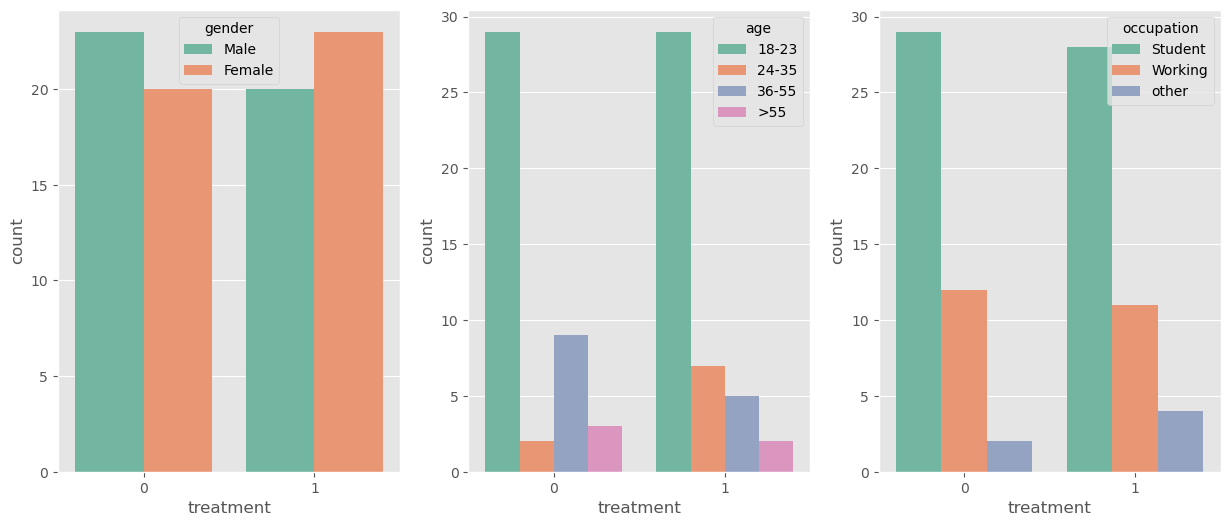

In [29]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
sns.countplot(data=sub[['gender', 'treatment']], x='treatment', hue='gender', ax = axes[0], palette='Set2')
sns.countplot(data=sub[['age', 'treatment']], x='treatment', hue='age', ax = axes[1], palette='Set2')
sns.countplot(data=sub[['occupation', 'treatment']], x='treatment', hue='occupation', ax = axes[2], palette='Set2')

## Regression

The treatment does not seem to be significant, no effect

In [30]:
sub['intercept'] = np.ones(len(sub))
temp = sub[['treatment', 'intercept', 'gender_bin', 'student_dummy', 'working_dummy',
       '24-35_dummy', '36-55_dummy', '>55_dummy']]
           
logit_model = sm.Logit(sub['outcome'],temp).fit(cov_type='HC3')
print(logit_model.summary())

Optimization terminated successfully.
         Current function value: 0.515872
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                   86
Model:                          Logit   Df Residuals:                       78
Method:                           MLE   Df Model:                            7
Date:                Wed, 29 Nov 2023   Pseudo R-squ.:                 0.04882
Time:                        22:10:40   Log-Likelihood:                -44.365
converged:                       True   LL-Null:                       -46.642
Covariance Type:                  HC3   LLR p-value:                    0.7142
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
treatment         0.6756      0.539      1.252      0.210      -0.382       1.733
intercept        -3.

#### Already subbed

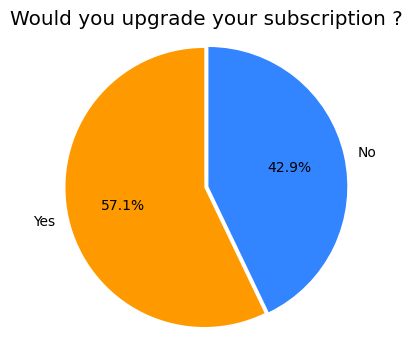

In [40]:
category_counts = subscribed['Q29'].value_counts()

labels = category_counts.index.tolist()
values = category_counts.values.tolist()

plt.figure(figsize=(4, 4))
plt.pie(values, labels=labels, autopct='%1.1f%%', startangle=90, explode=(0.03, 0), colors=['#ff9900', '#3385ff'])
plt.axis('equal') 
plt.title('Would you upgrade your subscription ?')
plt.show()

### Second theory - prices

#### Checks

In [32]:
tab = pd.DataFrame(['Chi-sq statistic', 'p_value'])
tab.columns = ['stat']
tab.index = tab['stat']

In [33]:
contingency_table = pd.crosstab(price['treatment'], price['gender'])
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

contingency_table['Total'] = contingency_table.sum(axis=1)
contingency_table.loc['Total'] = contingency_table.sum(axis=0)
table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')
tab['gender'] = [round(chi2_stat, 3), round(p_val, 3)]

print("Contingency Table:")
print(table_str)

print("Chi-squared test:")
print(f"  Chi-squared statistic: {chi2_stat:.4f}")
print(f"  Degrees of freedom: {dof}")
print(f"  P-value: {p_val:.4f}")

Contingency Table:
+---------------+--------+------+------------+-------+
|   treatment   | Female | Male | Non-binary | Total |
+---------------+--------+------+------------+-------+
|  dry_weekday  |   8    |  11  |     1      |  20   |
|  dry_weekend  |   12   |  10  |     0      |  22   |
| rainy_weekday |   9    |  9   |     1      |  19   |
| rainy_weekend |   12   |  11  |     0      |  23   |
|     Total     |   41   |  41  |     2      |  84   |
+---------------+--------+------+------------+-------+
Chi-squared test:
  Chi-squared statistic: 3.0586
  Degrees of freedom: 6
  P-value: 0.8015


In [34]:
contingency_table = pd.crosstab(price['treatment'], price['age'])
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

contingency_table['Total'] = contingency_table.sum(axis=1)
contingency_table.loc['Total'] = contingency_table.sum(axis=0)
table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')
tab['age'] = [round(chi2_stat, 3), round(p_val, 3)]

print("Contingency Table:")
print(table_str)

print("Chi-squared test:")
print(f"  Chi-squared statistic: {chi2_stat:.4f}")
print(f"  Degrees of freedom: {dof}")
print(f"  P-value: {p_val:.4f}")

Contingency Table:
+---------------+-------+-------+-------+-----+-------+
|   treatment   | 18-23 | 24-35 | 36-55 | >55 | Total |
+---------------+-------+-------+-------+-----+-------+
|  dry_weekday  |  12   |   2   |   3   |  3  |  20   |
|  dry_weekend  |  18   |   0   |   3   |  1  |  22   |
| rainy_weekday |  14   |   2   |   3   |  0  |  19   |
| rainy_weekend |  19   |   2   |   2   |  0  |  23   |
|     Total     |  63   |   6   |  11   |  4  |  84   |
+---------------+-------+-------+-------+-----+-------+
Chi-squared test:
  Chi-squared statistic: 10.0106
  Degrees of freedom: 9
  P-value: 0.3496


In [35]:
contingency_table = pd.crosstab(price['treatment'], price['occupation'])
chi2_stat, p_val, dof, expected = chi2_contingency(contingency_table)

contingency_table['Total'] = contingency_table.sum(axis=1)
contingency_table.loc['Total'] = contingency_table.sum(axis=0)
table_str = tabulate(contingency_table, headers='keys', tablefmt='pretty')
tab['occupation'] = [round(chi2_stat, 3), round(p_val, 3)]

print("Contingency Table:")
print(table_str)

print("Chi-squared test:")
print(f"  Chi-squared statistic: {chi2_stat:.4f}")
print(f"  Degrees of freedom: {dof}")
print(f"  P-value: {p_val:.4f}")

Contingency Table:
+---------------+---------+---------+-------+-------+
|   treatment   | Student | Working | other | Total |
+---------------+---------+---------+-------+-------+
|  dry_weekday  |   12    |    6    |   2   |  20   |
|  dry_weekend  |   16    |    5    |   1   |  22   |
| rainy_weekday |   14    |    5    |   0   |  19   |
| rainy_weekend |   15    |    4    |   4   |  23   |
|     Total     |   57    |   20    |   7   |  84   |
+---------------+---------+---------+-------+-------+
Chi-squared test:
  Chi-squared statistic: 5.4516
  Degrees of freedom: 6
  P-value: 0.4873


In [36]:
print(tabulate(tab.drop('stat', axis=1), headers='keys', tablefmt='grid'))

+------------------+----------+--------+--------------+
| stat             |   gender |    age |   occupation |
+==================+==========+========+==============+
| Chi-sq statistic |    3.059 | 10.011 |        5.452 |
+------------------+----------+--------+--------------+
| p_value          |    0.801 |  0.35  |        0.487 |
+------------------+----------+--------+--------------+


<Axes: xlabel='treatment', ylabel='count'>

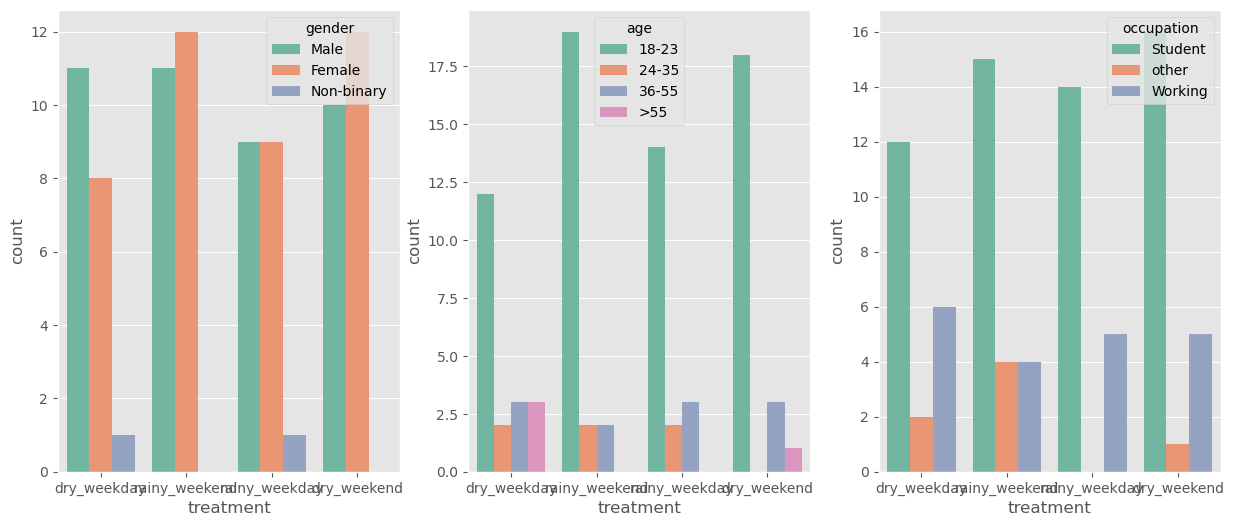

In [37]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))
sns.countplot(data=price[['gender', 'treatment']], x='treatment', hue='gender', ax = axes[0], palette='Set2')
sns.countplot(data=price[['age', 'treatment']], x='treatment', hue='age', ax = axes[1], palette='Set2')
sns.countplot(data=price[['occupation', 'treatment']], x='treatment', hue='occupation', ax = axes[2], palette='Set2')

### Regression

Only the treatment rain seems to be significant

In [38]:
temp = price[['treatment_rain', 'treatment_weekday', 'outcome', 'gender', 'occupation', 'age']].copy()
temp['interaction_term'] = temp['treatment_rain'] * temp['treatment_weekday']
temp['log_outcome'] = np.log(temp['outcome']+1)

model_1= ols('outcome ~  gender + occupation + age + treatment_rain + treatment_weekday + interaction_term', data=temp).fit(cov_type='HC3')
model_2 = ols('log_outcome ~  gender + occupation + age + treatment_rain + treatment_weekday + interaction_term', data=temp).fit(cov_type='HC3')

print('outcome ~  gender + occupation + age + treatment_rain + treatment_weekday + interaction_term')
print(model_1.summary(), '\n')

print('\nlog_outcome ~  gender + occupation + age + treatment_rain + treatment_weekday + interaction_term')
print(model_2.summary())

outcome ~  gender + occupation + age + treatment_rain + treatment_weekday + interaction_term
                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     2.382
Date:                Wed, 29 Nov 2023   Prob (F-statistic):             0.0167
Time:                        22:10:45   Log-Likelihood:                -120.51
No. Observations:                  84   AIC:                             263.0
Df Residuals:                      73   BIC:                             289.8
Df Model:                          10                                         
Covariance Type:                  HC3                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
---------------------------

In [39]:
model_3 = ols('outcome ~  gender + occupation + age + treatment_rain + treatment_weekday', data=temp).fit(cov_type='HC3')
model_4 = ols('log_outcome ~  gender + occupation + age + treatment_rain + treatment_weekday', data=temp).fit(cov_type='HC3')

print('outcome ~  gender + occupation + age + treatment_rain + treatment_weekday')
print(model_3.summary(), '\n')

print('\nlog_outcome ~  gender + occupation + age + treatment_rain + treatment_weekday')
print(model_4.summary())

outcome ~  gender + occupation + age + treatment_rain + treatment_weekday
                            OLS Regression Results                            
Dep. Variable:                outcome   R-squared:                       0.194
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     2.662
Date:                Wed, 29 Nov 2023   Prob (F-statistic):            0.00987
Time:                        22:10:46   Log-Likelihood:                -120.80
No. Observations:                  84   AIC:                             261.6
Df Residuals:                      74   BIC:                             285.9
Df Model:                           9                                         
Covariance Type:                  HC3                                         
                            coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------